# Header

In [1]:
import pandas as pd
import ezodf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import pandas_profiling as pp
import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment
from IPython.display import clear_output
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer, 
    MaxAbsScaler, QuantileTransformer, PowerTransformer
)
from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from sklearn.cluster import KMeans

/tmp/ipykernel_25989/3601355142.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


In [2]:
seed = 17

# Read file

In [3]:
def read_ods(filename, sheet_no=0, header=0):
    tab = ezodf.opendoc(filename=filename).sheets[sheet_no]
    return pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                        for col in tab.columns()})

In [4]:
tbtl = read_ods('./Data/label/tbtl-public.ods')
ck = pd.read_csv('./Data/ready_data/ready_ck.csv')
qt = pd.read_csv('./Data/ready_data/ready_qt.csv')

tbtl.TBTL = tbtl.TBTL.astype(float)

In [5]:
ck = ck[['username', 'CK']]
qt = qt[['username', 'diemqt']]

In [6]:
df = pd.read_csv('./Data/ready_data/ready_th.csv')

In [7]:
df.columns

Index(['username', 'count_submit', 'count_problem', 'avg_submit',
       'count_assignment', 'sum_pre_score', 'avg_pre_score', 'avg_coef',
       'time', 'ratio', 'point_hard', 'time_hard', 'avg_submit_hard', 'start',
       'max_problem', 'count_hard_problems', 'ratio_problem', 'hash', 'TH'],
      dtype='object')

In [8]:
df.drop(columns=['hash'], inplace=True)

In [9]:
df = pd.merge(df, ck, on='username', how='left')
df = pd.merge(df, qt, on='username', how='left')
df = pd.merge(df, tbtl, on='username', how='left')

In [10]:
df

,username,count_submit,count_problem,avg_submit,count_assignment,sum_pre_score,avg_pre_score,avg_coef,time,ratio,...,time_hard,avg_submit_hard,start,max_problem,count_hard_problems,ratio_problem,TH,CK,diemqt,TBTL
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,46,3.195652,7,460000,10000.000000,100.000000,2.0,6.571429,...,2.5,4.500000,0.285714,47.0,0.0,0.978723,5.0,5.5,7.5,7.24
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,78,3.320513,9,752499,9647.423077,100.000000,6.0,8.666667,...,14.5,3.416667,5.222222,96.0,0.0,0.812500,8.5,6.5,7.0,8.11
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,66,2.954545,7,615300,9322.727273,100.000000,6.0,9.428571,...,9.0,3.250000,0.714286,61.0,0.0,0.820896,7.0,4.5,9.0,7.30
3,013de369c439ab0ead8aa7da64423aa395a8be39,107,52,2.057692,8,465626,8954.346154,96.153846,9.0,6.500000,...,8.0,2.416667,2.500000,75.0,0.0,0.693333,10.0,5.0,10.0,8.20
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,199,90,2.211111,9,796000,8844.444444,100.000000,16.0,10.000000,...,16.0,2.500000,14.888889,103.0,0.0,0.873786,6.0,4.0,9.0,7.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,840d07858c03f80f4695056e2cc7d0c474b83a25,111,43,2.581395,6,414000,9627.906977,100.000000,12.0,7.166667,...,8.0,4.800000,8.166667,52.0,0.0,0.826923,6.0,5.5,9.0,7.67
757,844f5db2e7e31ae51eba025480679ed7e4708ac6,357,104,3.432692,17,1031846,9921.596154,100.000000,22.0,6.117647,...,7.0,4.842105,22.852941,111.0,0.0,0.936937,8.5,6.0,8.0,7.54
758,845acd04a77b3d1b623f255d9f9f8eae90892dab,155,52,2.980769,8,474000,9115.384615,100.000000,9.0,6.500000,...,7.0,6.000000,29.937500,67.0,0.0,0.776119,5.5,6.0,6.5,7.49
759,8460eaaf887a6289fb156f7562fb739ba8e9629e,557,114,4.885965,12,1106000,9701.754386,100.000000,7.0,9.500000,...,7.0,6.904762,11.416667,121.0,0.0,0.942149,10.0,7.0,10.0,8.94


In [11]:
df.describe()

,count_submit,count_problem,avg_submit,count_assignment,sum_pre_score,avg_pre_score,avg_coef,time,ratio,point_hard,time_hard,avg_submit_hard,start,max_problem,count_hard_problems,ratio_problem,TH,CK,diemqt,TBTL
count,761.000000,761.000000,761.000000,761.000000,7.610000e+02,761.000000,761.000000,761.000000,761.000000,761.000000,761.00000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,206.320631,64.148489,3.158201,7.402102,6.083412e+05,9088.483807,99.620383,9.174770,9.048095,102963.584757,8.35611,4.013664,11.529350,80.358739,0.099869,0.772873,7.288845,5.477483,8.294430,7.855427
std,139.638018,33.006662,1.385422,3.743232,3.263871e+05,1652.383707,2.419928,5.104146,4.807622,57143.334816,3.73893,2.182504,13.191073,38.492840,0.774945,0.190525,2.168836,2.144337,1.737223,0.904670
min,1.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,47.368421,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,3.000000,0.000000,0.100000,0.500000,0.000000,0.000000,2.520000
25%,112.000000,42.000000,2.266667,5.000000,3.745450e+05,9135.243902,100.000000,5.000000,6.076923,53846.000000,6.50000,2.611111,2.000000,53.000000,0.000000,0.691275,5.500000,4.000000,7.500000,7.330000
50%,191.000000,64.000000,2.906250,7.000000,6.137610e+05,9594.220000,100.000000,9.000000,7.818182,110000.000000,8.00000,3.666667,8.166667,83.000000,0.000000,0.819672,8.000000,5.500000,9.000000,7.930000
75%,280.000000,93.000000,3.756098,10.000000,8.920000e+05,9859.154930,100.000000,14.000000,11.600000,150000.000000,11.00000,5.000000,17.000000,112.000000,0.000000,0.910448,9.000000,7.000000,9.500000,8.540000
max,1019.000000,131.000000,12.500000,22.000000,1.284638e+06,10000.000000,100.000000,22.000000,30.000000,317774.000000,17.50000,17.600000,120.000000,165.000000,11.000000,1.000000,10.000000,10.000000,10.000000,9.610000


# CK

In [12]:
ck_df = df.drop(columns=['TH', 'diemqt', 'TBTL'])

In [13]:
def experiment(df, id='username', target='CK', dev=False, seed=17):
    df.dropna(inplace=True)
    results = []

    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'Normalizer': Normalizer(),
        'MaxAbsScaler': MaxAbsScaler(),
        'QuantileTransformer': QuantileTransformer(),
        'PowerTransformer': PowerTransformer(method='yeo-johnson')
    }

    for scaler_name, scaler in scalers.items():
        df_scaled = df.copy()

        # Apply the scaler to all columns except the target and id
        if id in df_scaled.columns and target in df_scaled.columns:
            features = df_scaled.drop(columns=[id, target]).columns
        elif id in df_scaled.columns:
            features = df_scaled.drop(columns=[id]).columns
        elif target in df_scaled.columns:
            features = df_scaled.drop(columns=[target]).columns
        else:
            features = df_scaled.columns
        
        df_scaled[features] = scaler.fit_transform(df_scaled[features])
        df_scaled[target] = df[target]

        # Run the model training and evaluation
        s = setup(data=df_scaled.drop(columns=[id]), target=target, use_gpu=True, profile=False, session_id=seed)
        clear_output()
        best_model = compare_models(fold=5, sort='R2', verbose=False)
        result = pull()
        result = result[['Model', 'R2']]
        result = result[result['R2'] > 0.2]
        if dev:
            result = result.head(1)
        result['Scaler'] = scaler_name
        results.append(result)

    # Combine results from all scalers into a single DataFrame
    final_results = pd.concat(results, ignore_index=True)
    return final_results

## inital result

In [14]:
s = setup(data = ck_df.drop(columns=['username']), target = 'CK', use_gpu=True, profile=False, session_id=seed)
clear_output()
best_model = compare_models(fold=5, sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.5716,3.8814,1.9698,0.1523,0.4097,0.4353,0.0820
rf,Random Forest Regressor,1.5719,3.8965,1.9730,0.1503,0.4117,0.4344,0.1180
catboost,CatBoost Regressor,1.5800,3.9156,1.9782,0.1451,0.4083,0.4274,5.2260
ridge,Ridge Regression,1.5892,3.9532,1.9863,0.1368,0.4181,0.4514,0.0080
lr,Linear Regression,1.5914,3.9582,1.9874,0.1359,0.4181,0.4511,0.0080
br,Bayesian Ridge,1.5929,3.9580,1.9887,0.1356,0.4197,0.4519,0.0080
lar,Least Angle Regression,1.6083,4.0376,2.0066,0.1198,0.4199,0.4552,0.0100
ada,AdaBoost Regressor,1.6097,4.0371,2.0079,0.1186,0.4147,0.4264,0.0600
en,Elastic Net,1.6150,4.0467,2.0112,0.1159,0.4235,0.4549,0.0080
gbr,Gradient Boosting Regressor,1.6257,4.1457,2.0349,0.0961,0.4193,0.4251,0.1160


## EDA

In [ ]:
pp.ProfileReport(ck_df)

In [16]:
def draw_scatter_plot(x, y, df=ck_df, x_threshold=None, y_threshold=None):
    def categorize_CK(ck):
        if ck < 5:
            return 'CK < 5'
        elif 5 <= ck < 8:
            return '5 < CK < 8'
        elif 8 <= ck <= 10:
            return '8 < CK < 10'
        else:
            return 'Other'  # To handle TH values outside the specified ranges
        
    df['CK_category'] = df['CK'].apply(categorize_CK)
    sns.scatterplot(data=df, x=x, y=y, hue='CK_category')
    if x_threshold is not None:
        plt.axvline(x=x_threshold, color='red', linestyle='--', linewidth=2)
    if y_threshold is not None:
        plt.axhline(y=y_threshold, color='red', linestyle='--', linewidth=2)

### point hard vs time

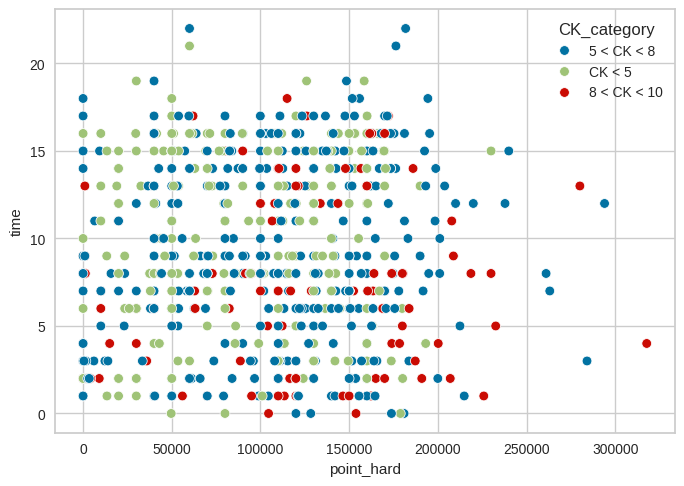

In [20]:
draw_scatter_plot('point_hard', 'time')

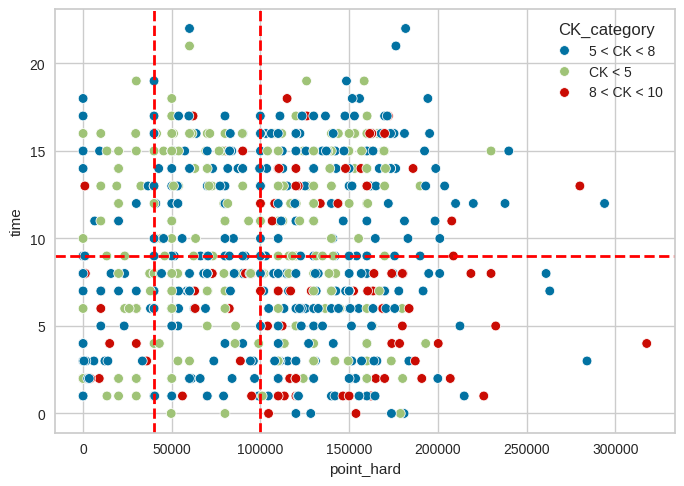

In [21]:
sns.scatterplot(x=ck_df.point_hard, y=ck_df.time, hue=ck_df.CK_category)
plt.axvline(x=40_000, color='red', linestyle='--', linewidth=2)
plt.axvline(x=100_000, color='red', linestyle='--', linewidth=2)
plt.axhline(y=9, color='red', linestyle='--', linewidth=2)
plt.show()

### count problem vs avg submit

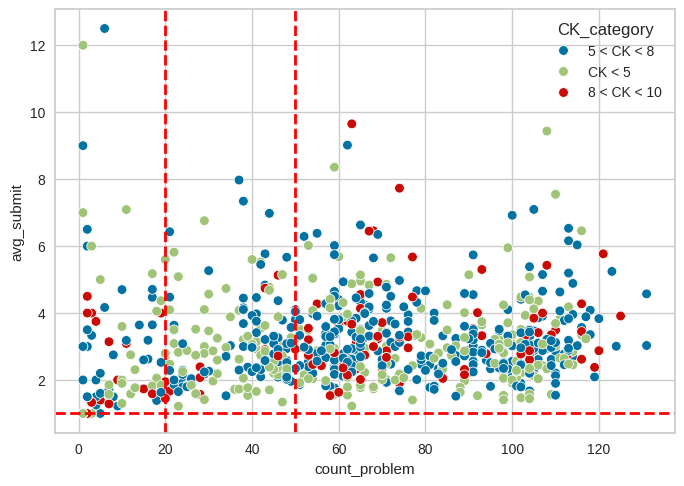

In [22]:
sns.scatterplot(x=ck_df.count_problem, y=ck_df.avg_submit, hue=ck_df.CK_category)
plt.axvline(x=50, color='red', linestyle='--', linewidth=2)
plt.axvline(x=20, color='red', linestyle='--', linewidth=2)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2)

### count_problem vs avg_coef

[]

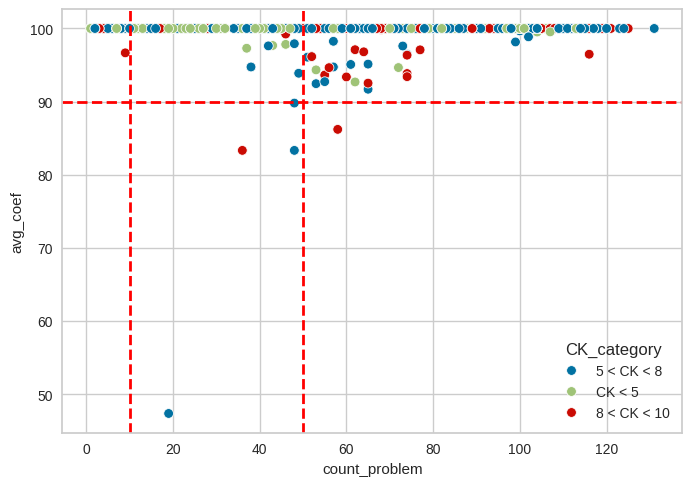

In [23]:
sns.scatterplot(x=ck_df.count_problem, y=ck_df.avg_coef, hue=ck_df.CK_category)
plt.axvline(x=10, color='red', linestyle='--', linewidth=2)
plt.axvline(x=50, color='red', linestyle='--', linewidth=2)
plt.axhline(y=90, color='red', linestyle='--', linewidth=2)
plt.plot()

### count problem

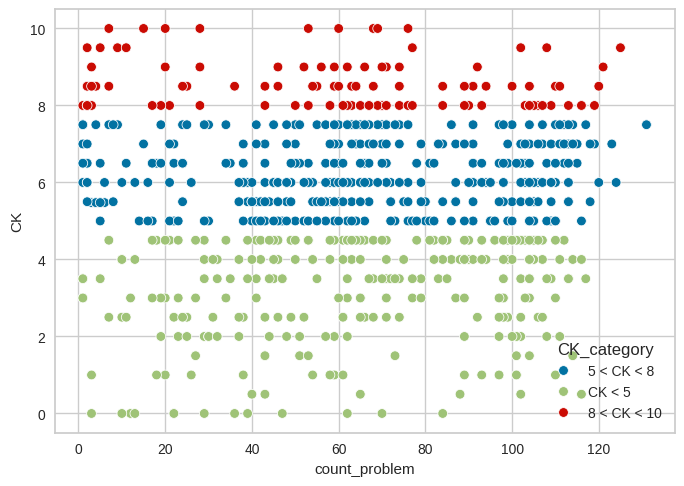

In [24]:
draw_scatter_plot('count_problem', 'CK')

### count assignment

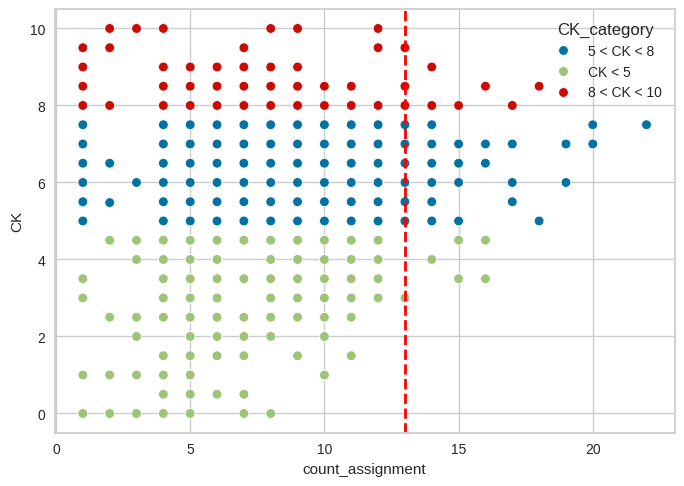

In [25]:
draw_scatter_plot('count_assignment', 'CK', x_threshold=13)

### max problem

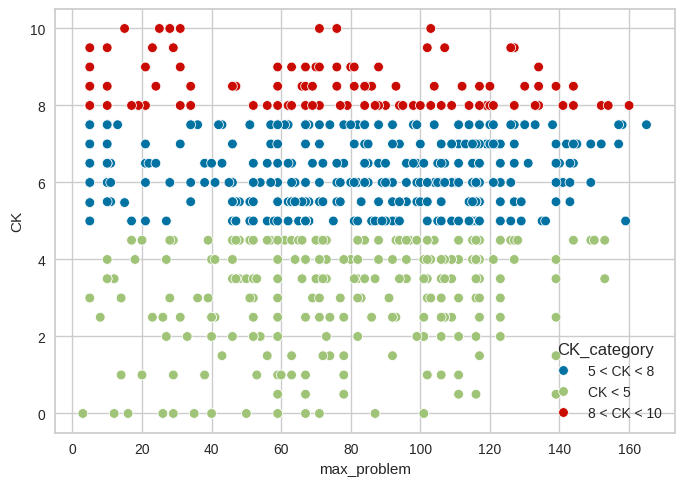

In [26]:
draw_scatter_plot('max_problem', 'CK')

### count hard problem

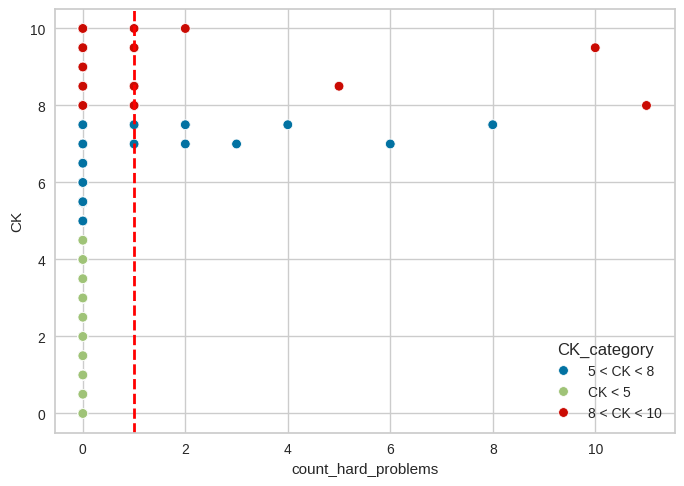

In [27]:
draw_scatter_plot('count_hard_problems', 'CK', x_threshold=1)

### point_hard/avg_submit vs count_submit

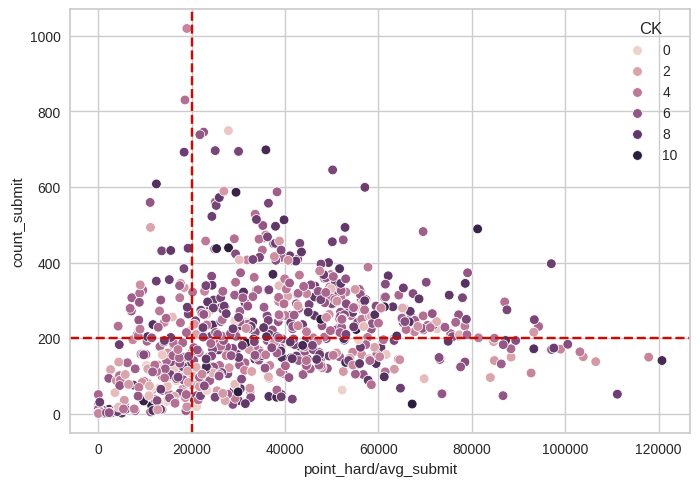

In [28]:
sns.scatterplot(x=ck_df.point_hard/ck_df.avg_submit, y=ck_df.count_submit, hue=ck_df.CK)
plt.xlabel('point_hard/avg_submit')
plt.axvline(x=20000, color='r', linestyle='--')
plt.axhline(y=200, color='r', linestyle='--')

## Feature engineering

In [29]:
def ck_preprocess(df):
    df_copy = df.copy()
    
    df_copy['point_hard_vs_time'] = (df_copy.point_hard >= 40_000) & (df_copy.point_hard <= 100_000) & (df_copy.time >= 9) 
    df_copy['count_problem_vs_avg_submit'] = (df_copy.count_problem >= 20) & (df_copy.count_problem <= 50) & (df_copy.avg_submit >= 1)
    df_copy['count_problem_vs_avg_coef'] = (df_copy.count_problem >= 10) & (df_copy.count_problem <= 50) & (df_copy.avg_coef >= 90)
    df_copy['count_assignment'] = df_copy.count_assignment >= 13
    df_copy['count_hard_problems'] = df_copy.count_hard_problems >= 1
    df_copy['point_hard/avg_submit_vs_count_submit'] = (df_copy.point_hard/df_copy.avg_submit >= 20_000) & (df_copy.count_submit <= 200)
    return df_copy

In [30]:
if 'CK_category' in ck_df.columns:
    ck_df.drop(columns=['CK_category'], inplace=True)

In [32]:
train_df = ck_preprocess(ck_df)

In [33]:
len(ck_df.columns), len(train_df.columns)

(18, 22)

### second experiment

In [34]:
s = setup(data = train_df.drop(columns=['username']), target = 'CK', use_gpu=True, profile=False, session_id=seed)
clear_output()
best_model = compare_models(fold=5, sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,1.5351,3.7387,1.9323,0.1828,0.4060,0.4316,0.0120
lr,Linear Regression,1.5392,3.7528,1.9358,0.1800,0.4058,0.4312,0.0140
catboost,CatBoost Regressor,1.5693,3.8167,1.9529,0.1664,0.4068,0.4309,5.1320
lar,Least Angle Regression,1.5594,3.8387,1.9576,0.1614,0.4075,0.4381,0.0180
rf,Random Forest Regressor,1.5708,3.8670,1.9656,0.1557,0.4118,0.4374,0.1220
et,Extra Trees Regressor,1.5526,3.8752,1.9673,0.1502,0.4096,0.4335,0.0820
br,Bayesian Ridge,1.5934,3.9546,1.9880,0.1363,0.4195,0.4523,0.0120
ada,AdaBoost Regressor,1.6148,4.0412,2.0089,0.1165,0.4152,0.4358,0.0640
en,Elastic Net,1.6150,4.0467,2.0112,0.1159,0.4235,0.4549,0.0120
gbr,Gradient Boosting Regressor,1.6481,4.1155,2.0274,0.1005,0.4214,0.4498,0.1140


## Feature selection

In [35]:
selector = RFECV(estimator=CatBoostRegressor(random_seed=seed, verbose=False),
                 cv=5, scoring='r2', n_jobs=-1)

In [36]:
selector.fit(train_df.drop(columns=['CK', 'username']), train_df['CK'])

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7e113a907640>,
      n_jobs=-1, scoring='r2')

In [37]:
np.save('./Data/ck_selector_support.npy', selector.support_)

In [38]:
selector_support = np.load('./Data/ck_selector_support.npy')

In [39]:
selected_features = train_df.drop(columns=['CK', 'username']).columns[selector_support]

In [40]:
df_train = train_df[['username', 'CK'] + list(selected_features)]

## pipeline

### preprocessing

In [41]:
def th_preprocessing(df_train, df_test):
    
    train = ck_preprocess(df_train)
    test = ck_preprocess(df_test)
    
    selector_support = np.load('./Data/ck_selector_support.npy')
    train = train[['username', 'CK'] + list(train.drop(columns=['CK', 'username']).columns[selector_support])]
    test = test[['username'] + list(test.drop(columns=['username']).columns[selector_support])]
    
    scaler = Normalizer()
    features = train.drop(columns=['username', 'CK']).columns
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])
    
    return train, test

In [42]:
test = pd.read_csv('./Data/work_data.csv')
test = test[~test.username.isin(ck_df.username)]

In [43]:
df_train, df_test = th_preprocessing(ck_df, test)

## modelling

In [44]:
s = setup(data = df_train.drop(columns=['username']), target = 'CK', use_gpu=True, profile=False, session_id=seed)
clear_output()
top5 = compare_models(fold=5, sort='R2', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.5267,3.6953,1.9203,0.1915,0.4055,0.4302,0.1200
gbr,Gradient Boosting Regressor,1.5444,3.8055,1.9503,0.1674,0.4069,0.4333,0.1260
catboost,CatBoost Regressor,1.5724,3.8825,1.9698,0.1498,0.4132,0.4372,5.1020
et,Extra Trees Regressor,1.5578,3.9617,1.9879,0.1311,0.4157,0.4451,0.0800
ada,AdaBoost Regressor,1.6191,4.1258,2.0290,0.0974,0.4163,0.4236,0.0660
lightgbm,Light Gradient Boosting Machine,1.6536,4.3084,2.0748,0.0568,0.4288,0.4540,0.3240
omp,Orthogonal Matching Pursuit,1.7063,4.5479,2.1318,0.0075,0.4496,0.5065,0.0080
ridge,Ridge Regression,1.7127,4.5646,2.1358,0.0039,0.4499,0.5083,0.0080
br,Bayesian Ridge,1.7147,4.5774,2.1387,0.0013,0.4502,0.5092,0.0080
llar,Lasso Least Angle Regression,1.7210,4.6418,2.1536,-0.0124,0.4515,0.5114,0.0080


### hypertune

In [45]:
tuned_top5 = [tune_model(model, fold=5, n_iter=100, 
                         optimize='MAE', search_library='optuna', choose_better=True) for model in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5106,3.5989,1.8971,0.1604,0.4318,0.4107
1,1.6400,4.3029,2.0744,0.0655,0.4028,0.3908
2,1.4008,3.2913,1.8142,0.2754,0.4045,0.4436
3,1.5223,3.5648,1.8881,0.2962,0.3721,0.4731
4,1.5231,3.6674,1.9150,0.1719,0.4209,0.4436
Mean,1.5194,3.6851,1.9177,0.1939,0.4064,0.4324
Std,0.0758,0.3344,0.0855,0.0839,0.0203,0.0287


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5330,3.6966,1.9226,0.1376,0.4337,0.4011
1,1.6351,4.1104,2.0274,0.1073,0.3939,0.3887
2,1.4699,3.6277,1.9047,0.2013,0.4169,0.4610
3,1.4855,3.5155,1.8750,0.3060,0.3694,0.4755
4,1.5296,3.8395,1.9595,0.1330,0.4326,0.4616
Mean,1.5306,3.7579,1.9378,0.1770,0.4093,0.4376
Std,0.0577,0.2051,0.0525,0.0715,0.0246,0.0355


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5266,3.6509,1.9107,0.1482,0.4344,0.4095
1,1.6226,4.0228,2.0057,0.1263,0.3865,0.3800
2,1.4712,3.5548,1.8854,0.2173,0.4174,0.4602
3,1.5630,3.6684,1.9153,0.2758,0.3823,0.4860
4,1.5480,3.7466,1.9356,0.1540,0.4279,0.4529
Mean,1.5463,3.7287,1.9306,0.1843,0.4097,0.4377
Std,0.0493,0.1592,0.0408,0.0548,0.0214,0.0379


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4874,3.6144,1.9012,0.1568,0.4354,0.4184
1,1.6371,4.3151,2.0773,0.0629,0.4009,0.3937
2,1.4370,3.5025,1.8715,0.2288,0.4139,0.4669
3,1.5075,3.4553,1.8589,0.3178,0.3780,0.4983
4,1.5570,3.8342,1.9581,0.1342,0.4304,0.4690
Mean,1.5252,3.7443,1.9334,0.1801,0.4117,0.4493
Std,0.0679,0.3139,0.0797,0.0869,0.0208,0.0378


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5148,3.5772,1.8914,0.1654,0.4274,0.4036
1,1.6969,4.4284,2.1044,0.0383,0.3972,0.3880
2,1.4301,3.3670,1.8349,0.2587,0.4119,0.4541
3,1.6320,3.8604,1.9648,0.2379,0.3771,0.4650
4,1.5823,3.8786,1.9694,0.1242,0.4277,0.4549
Mean,1.5712,3.8223,1.9530,0.1649,0.4083,0.4331
Std,0.0924,0.3576,0.0906,0.0798,0.0192,0.0311


In [46]:
blender = blend_models(estimator_list=tuned_top5, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4949,3.5391,1.8812,0.1743,0.4302,0.4045
1,1.6334,4.1345,2.0333,0.1021,0.3924,0.3855
2,1.4102,3.3658,1.8346,0.2589,0.4094,0.4505
3,1.5285,3.5079,1.8729,0.3075,0.3728,0.4768
4,1.5291,3.6917,1.9214,0.1664,0.4251,0.4529
Mean,1.5192,3.6478,1.9087,0.2018,0.4060,0.4340
Std,0.0717,0.2644,0.0681,0.0726,0.0212,0.0337


In [47]:
stacker = stack_models(estimator_list=tuned_top5, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5009,3.5876,1.8941,0.1630,0.4330,0.4113
1,1.6255,4.1466,2.0363,0.0994,0.3923,0.3874
2,1.4376,3.5007,1.8710,0.2293,0.4162,0.4653
3,1.5486,3.5729,1.8902,0.2946,0.3803,0.4891
4,1.5516,3.8484,1.9617,0.1310,0.4343,0.4729
Mean,1.5328,3.7313,1.9307,0.1835,0.4112,0.4452
Std,0.0621,0.2388,0.0611,0.0703,0.0217,0.0390


### save load model

In [49]:
save_model(stacker, './model/CK/stacker')
save_model(blender, './model/CK/blender')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['count_submit', 'count_problem',
                                              'avg_submit', 'count_assignment',
                                              'sum_pre_score', 'avg_pre_score',
                                              'avg_coef', 'time', 'ratio',
                                              'point_hard', 'time_hard',
                                              'avg_submit_hard', 'start',
                                              'max_problem',
                                              'count_hard_problems',
                                              'ratio_problem',
                                              'point_hard_vs_time',
                                              'count_prob...
                                              ('Extra Trees Regressor',
                                               ExtraTreesRegressor

In [50]:
stacker = load_model('./model/CK/stacker')
blender = load_model('./model/CK/blender')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [51]:
from sklearn import set_config
set_config(display='diagram')
stacker

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['count_submit', 'count_problem',
                                             'avg_submit', 'count_assignment',
                                             'sum_pre_score', 'avg_pre_score',
                                             'avg_coef', 'time', 'ratio',
                                             'point_hard', 'time_hard',
                                             'avg_submit_hard', 'start',
                                             'max_problem',
                                             'count_hard_problems',
                                             'ratio_problem',
                                             'point_hard_vs_time',...
                                                ExtraTreesRegressor(bootstrap=True,
                                                                    max_depth=11,
                                                                    max_features=0.8573470651269514,
                                                                    min_impurity_decrease=2.4540083369373185e-05,
                                                                    min_samples_leaf=2,
                                                                    min_samples_split=8,
                                                                    n_estimators=115,
                                                                    n_jobs=-1,
                                                                    random_state=17)),
                                               ('AdaBoost Regressor',
                                                AdaBoostRegressor(learning_rate=0.0638061773244001,
                                                                  n_estimators=185,
                                                                  random_state=17))],
                                   final_estimator=LinearRegression(n_jobs=-1),
                                   n_jobs=1))])

In [52]:
blender

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['count_submit', 'count_problem',
                                             'avg_submit', 'count_assignment',
                                             'sum_pre_score', 'avg_pre_score',
                                             'avg_coef', 'time', 'ratio',
                                             'point_hard', 'time_hard',
                                             'avg_submit_hard', 'start',
                                             'max_problem',
                                             'count_hard_problems',
                                             'ratio_problem',
                                             'point_hard_vs_time',...
                                             ('Extra Trees Regressor',
                                              ExtraTreesRegressor(bootstrap=True,
                                                                  max_depth=11,
                                                                  max_features=0.8573470651269514,
                                                                  min_impurity_decrease=2.4540083369373185e-05,
                                                                  min_samples_leaf=2,
                                                                  min_samples_split=8,
                                                                  n_estimators=115,
                                                                  n_jobs=-1,
                                                                  random_state=17)),
                                             ('AdaBoost Regressor',
                                              AdaBoostRegressor(learning_rate=0.0638061773244001,
                                                                n_estimators=185,
                                                                random_state=17))],
                                 n_jobs=1))])

### predict

In [55]:
predict = predict_model(blender, data=df_test.drop(columns=['username']))

In [56]:
submit = pd.DataFrame({'username': test.username, 'CK': predict.prediction_label})
submit.to_csv('./ck_submit.csv', index=False, header=False)